In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as stats


from sb_utils import save_file

In [2]:
cat_data = pd.read_csv('./Data/cat_clean.csv')

In [3]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5726 entries, 0 to 5725
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     5726 non-null   float64
 1   Gender                  5726 non-null   int64  
 2   Neuter_status           5726 non-null   int64  
 3   Breed_group             5726 non-null   object 
 4   Weaning_age             5726 non-null   int64  
 5   Outdoors                5726 non-null   int64  
 6   Other_cats              5726 non-null   int64  
 7   Activity_level          5726 non-null   int64  
 8   Contact_people          5726 non-null   int64  
 9   Aggression_stranger     5726 non-null   int64  
 10  Aggression_owner        5726 non-null   int64  
 11  Aggression_cats         5726 non-null   int64  
 12  Shyness_novel           5726 non-null   int64  
 13  Shyness_strangers       5726 non-null   int64  
 14  Grooming                5726 non-null   

Why isn't my data clean anymore???? I'm missing values :(

Andrea Constantinof  to  Everyone 6:43 PM
select_data = pd.DataFrame(list(zip(selected_license, selected_sales_group)), columns =['Selected_License', 'Selected_Sales_Group'])
selected_license =[]
selected_sales_group = []

## Chi-Squared Heatmap: Why is EDA on ordinal variables literally the worst?
Thank you shafqaatahma, you beautiful blessing to this world. See source code for chi2 heatmap [here](https://github.com/shafqaatahmad/chisquare-test-heatmap).

In [4]:
# Heatmap of chi2 p-values except for the components since obviously
# there will be multicollinearity there, and age as it is continuous. 
no_comps_only_cat = cat_data.drop(columns=['Aggression_component', 'Extraversion_component', 'Shyness_component', 'Age'])
column_names=no_comps_only_cat.columns

chisqmatrix=pd.DataFrame(no_comps_only_cat,columns=column_names,index=column_names)

outercnt=0
innercnt=0
for icol in column_names:
    
    for jcol in column_names:
        
       mycrosstab=pd.crosstab(no_comps_only_cat[icol], no_comps_only_cat[jcol])
       #print (mycrosstab)
       stat,p,dof,expected=stats.chi2_contingency(mycrosstab)
       chisqmatrix.iloc[outercnt,innercnt]=round(p,3)
       cntexpected=expected[expected<5].size
       perexpected=((expected.size-cntexpected)/expected.size)*100
      
       #print (icol)
       #print (jcol)
       if perexpected<20:
            chisqmatrix.iloc[outercnt,innercnt]=2
       #print (perexpected) 
       if icol==jcol:
           chisqmatrix.iloc[outercnt,innercnt]=0.00
       #print (expected) 
       innercnt=innercnt+1
    #print (outercnt) 
    outercnt=outercnt+1
    innercnt=0

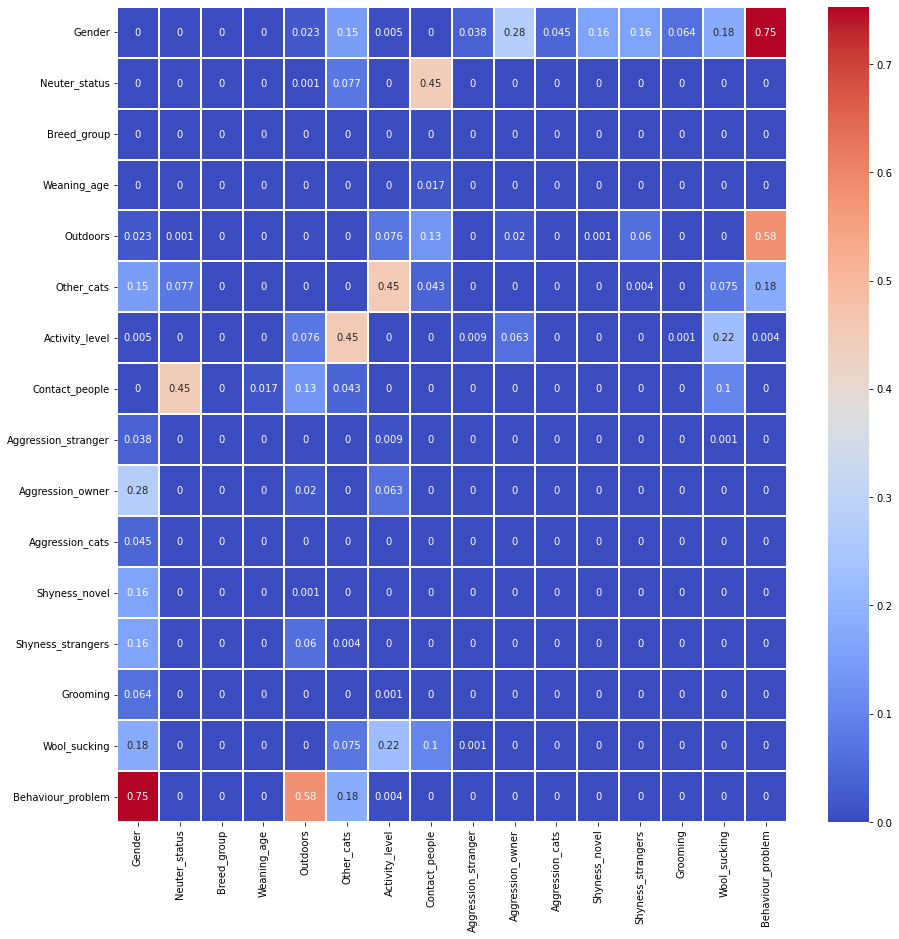

In [5]:
plt.subplots(figsize=(15, 15))
sns.heatmap(chisqmatrix.astype(np.float64), annot=True,linewidths=0.1, 
            cmap='coolwarm');

05/03/2023: I don't even remember what this ^ is supposed to be telling me anymore. I thought chi squared values are supposed to be between -1 and 1. I'm pretty sure the goal was to get a quick idea of any relationships before looking but oh well. 

Everything seems to be correlated with everything? I think for grins and giggles we're going to treat Wool_sucking as our dependent variable for now. I feel like Weaning_age makes sense as a potential explanatory variable. Additionally:
* Neuter_status
* Breed_group
* All aggression and shyness categories, and behavior problem (I hypothesize the same factors that lead to wool sucking also lead to waryness of new things and general behavioral issues. I don't think these are causational in nature at all.)
* Excessive grooming. (Ditto to above comment, I think factors leading to wool_sucking (a de-stresser) also likely lead to excessiev grooming (also a de-stresser). 

05/03/2023: Yeah I'm not getting any of those same numbers anymore?? ^ 

In [6]:
# I don't understand how 10% of cats were "not weaned", the questionnaire asks when was the cat separated from its mother?
# So, I am assuming the four year old cats that are 8's are not drinking breast milk still, rather, they just weren't separated 
# from mom ever. 
cat_data.Weaning_age.value_counts(normalize=True)

4    0.477122
5    0.176388
8    0.100768
6    0.100768
3    0.054314
2    0.038945
1    0.030912
7    0.020782
Name: Weaning_age, dtype: float64

In [7]:
WA_WS_crosstab = (pd.crosstab(cat_data.Weaning_age, cat_data.Wool_sucking))
new_cols = {0.0:'WS_0', 1.0:'WS_1', 2.0:"WS_2", 3.0:'WS_3', 4.0:'WS_4', 5.0:'WS_5', 6.0:'WS_6', 7.0:'WS_7'}
word_cols = {0.0:'never', 1.0:'1-3 times/lifetime', 2.0:'1-12 times/year', 3.0:'1-4 times/month', 4.0:'1-3 times/week', 5.0:'daily', 6.0:'many times/day', 7.0:'most of the day'}
WA_WS_crosstab = WA_WS_crosstab.rename(columns=new_cols)

In [8]:
WA_WS_crosstab

Wool_sucking,WS_0,WS_1,WS_2,WS_3,WS_4,WS_5,WS_6,WS_7
Weaning_age,,,,,,,,
1,100,18,11,12,22,11,3,0
2,131,11,22,21,24,12,2,0
3,194,16,30,22,34,15,0,0
4,1854,172,202,196,196,97,13,2
5,686,78,65,63,72,41,5,0
6,392,39,45,41,41,18,1,0
7,103,4,2,3,7,0,0,0
8,461,30,26,20,25,13,2,0


* Wool_sucking (0 = never, 1 = 1-3 times in the cat's lifetime, 2 = 1-12 times a year, 3 = 1-4 times a month, 4 = 1-3 times a week, 5 = daily, 6 = many times per day, 7 = most of the day)
* When was the cat separated from its mother?
  *  1 = before 8 weeks
  * 2 = at 8-9 weeks
  *  3 = at 10-11 weeks
  *  4 = at 12-13 weeks
  *  5 = at 14-15 weeks
  *  6 = at 16 weeks - 1 year
  *  7 = in adulthood
  *  8 = not weaned

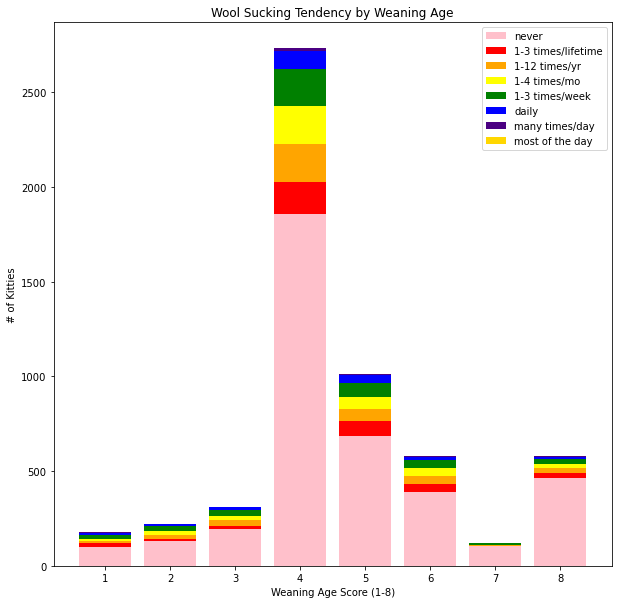

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(WA_WS_crosstab.index, WA_WS_crosstab['WS_0'], 
       color="pink", label="never")
ax.bar(WA_WS_crosstab.index, WA_WS_crosstab['WS_1'], 
       bottom=WA_WS_crosstab['WS_0'],
       color="red", label="1-3 times/lifetime")
ax.bar(WA_WS_crosstab.index, WA_WS_crosstab['WS_2'], 
       bottom=WA_WS_crosstab['WS_0']+WA_WS_crosstab['WS_1'],
       color="orange", label="1-12 times/yr")
ax.bar(WA_WS_crosstab.index, WA_WS_crosstab['WS_3'], 
       bottom=WA_WS_crosstab['WS_0']+WA_WS_crosstab['WS_1']+WA_WS_crosstab['WS_2'],
       color="yellow", label="1-4 times/mo")
ax.bar(WA_WS_crosstab.index, WA_WS_crosstab['WS_4'], 
        bottom=WA_WS_crosstab['WS_0']+WA_WS_crosstab['WS_1']+WA_WS_crosstab['WS_2']+WA_WS_crosstab['WS_3'],
       color="green", label="1-3 times/week")
ax.bar(WA_WS_crosstab.index, WA_WS_crosstab['WS_5'], 
       bottom=WA_WS_crosstab['WS_0']+WA_WS_crosstab['WS_1']+WA_WS_crosstab['WS_2']+WA_WS_crosstab['WS_3']+WA_WS_crosstab['WS_4'],
       color="blue", label="daily")
ax.bar(WA_WS_crosstab.index, WA_WS_crosstab['WS_6'], 
       bottom=WA_WS_crosstab['WS_0']+WA_WS_crosstab['WS_1']+WA_WS_crosstab['WS_2']+WA_WS_crosstab['WS_3']+WA_WS_crosstab['WS_4']+WA_WS_crosstab['WS_5'],
       color="indigo", label="many times/day")
ax.bar(WA_WS_crosstab.index, WA_WS_crosstab['WS_7'], 
       bottom=WA_WS_crosstab['WS_0']+WA_WS_crosstab['WS_1']+WA_WS_crosstab['WS_2']+WA_WS_crosstab['WS_3']+WA_WS_crosstab['WS_4']+WA_WS_crosstab['WS_5']+WA_WS_crosstab['WS_6'],
       color="gold", label="most of the day")
ax.legend()
ax.set_xlabel('Weaning Age Score (1-8)')
ax.set_ylabel('# of Kitties')
plt.title('Wool Sucking Tendency by Weaning Age')
plt.show();

In [10]:
cat_data["Weaning_age"].value_counts(normalize=True)

4    0.477122
5    0.176388
8    0.100768
6    0.100768
3    0.054314
2    0.038945
1    0.030912
7    0.020782
Name: Weaning_age, dtype: float64

In [11]:
# Dropping weaning age score of 4  --- I'm sure there's a way to drop an index row but this way didn't require Googling!
tp = WA_WS_crosstab.T       # transpose
tp = tp.drop(columns=[4])   # drop 4
WA_WS_no4 = tp.T            # transpose back  
WA_WS_no4

Wool_sucking,WS_0,WS_1,WS_2,WS_3,WS_4,WS_5,WS_6,WS_7
Weaning_age,,,,,,,,
1,100,18,11,12,22,11,3,0
2,131,11,22,21,24,12,2,0
3,194,16,30,22,34,15,0,0
5,686,78,65,63,72,41,5,0
6,392,39,45,41,41,18,1,0
7,103,4,2,3,7,0,0,0
8,461,30,26,20,25,13,2,0


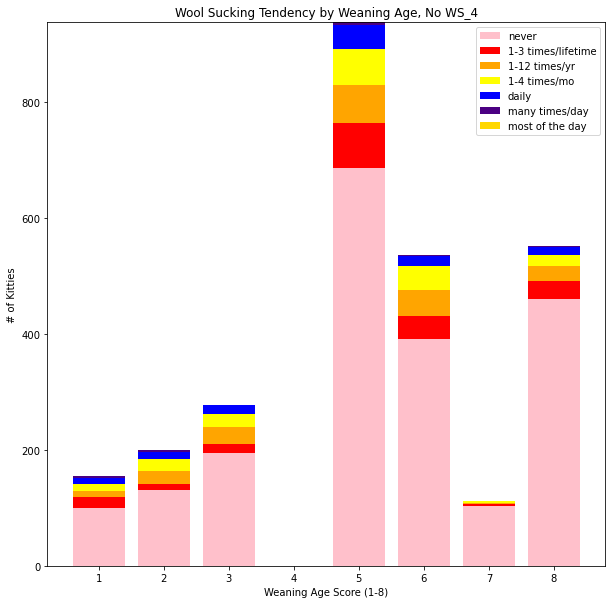

In [12]:
# I wanted to be able to see these on a better scale 
fig2, ax2 = plt.subplots(figsize=(10, 10))
ax2.bar(WA_WS_no4.index, WA_WS_no4['WS_0'], 
       color="pink", label="never")
ax2.bar(WA_WS_no4.index, WA_WS_no4['WS_1'], 
       bottom=WA_WS_no4['WS_0'],
       color="red", label="1-3 times/lifetime")
ax2.bar(WA_WS_no4.index, WA_WS_no4['WS_2'], 
       bottom=WA_WS_no4['WS_0']+WA_WS_no4['WS_1'],
       color="orange", label="1-12 times/yr")
ax2.bar(WA_WS_no4.index, WA_WS_no4['WS_3'], 
       bottom=WA_WS_no4['WS_0']+WA_WS_no4['WS_1']+WA_WS_no4['WS_2'],
       color="yellow", label="1-4 times/mo")
ax2.bar(WA_WS_no4.index, WA_WS_no4['WS_5'], 
       bottom=WA_WS_no4['WS_0']+WA_WS_no4['WS_1']+WA_WS_no4['WS_2']+WA_WS_no4['WS_3'],
       color="blue", label="daily")
ax2.bar(WA_WS_no4.index, WA_WS_no4['WS_6'], 
       bottom=WA_WS_no4['WS_0']+WA_WS_no4['WS_1']+WA_WS_no4['WS_2']+WA_WS_no4['WS_3']+WA_WS_no4['WS_5'],
       color="indigo", label="many times/day")
ax2.bar(WA_WS_no4.index, WA_WS_no4['WS_7'], 
       bottom=WA_WS_no4['WS_0']+WA_WS_no4['WS_1']+WA_WS_no4['WS_2']+WA_WS_no4['WS_3']+WA_WS_no4['WS_5']+WA_WS_no4['WS_6'],
       color="gold", label="most of the day")
ax2.legend()
ax2.set_xlabel('Weaning Age Score (1-8)')
ax2.set_ylabel('# of Kitties')
ax2.set_title('Wool Sucking Tendency by Weaning Age, No WS_4')
plt.show();

In [13]:
stat, p, dof, expected = stats.chi2_contingency(WA_WS_crosstab)

In [14]:
# just double-checking the result we got from the heat map. 
p = round(p, 5)
p

0.0

## Rejecting the Null:
* Null Hypothesis: Weaning age and wool sucking are independent variables. They are not correlated. 
* **Alt Hypothesis: Weaning age and wool sucking are correlated.**

P-Value = 0.0, i.e., we would not expect to see this relationship due to unavoidable and natural variability. We should reject the null hypothesis. 

# Neuter Status - Grouped Bar

In [15]:
# Neuter Status Cont. Table
ns = pd.crosstab(cat_data.Neuter_status, cat_data.Wool_sucking)
ns = ns.rename(columns=word_cols)
xns = ns.index

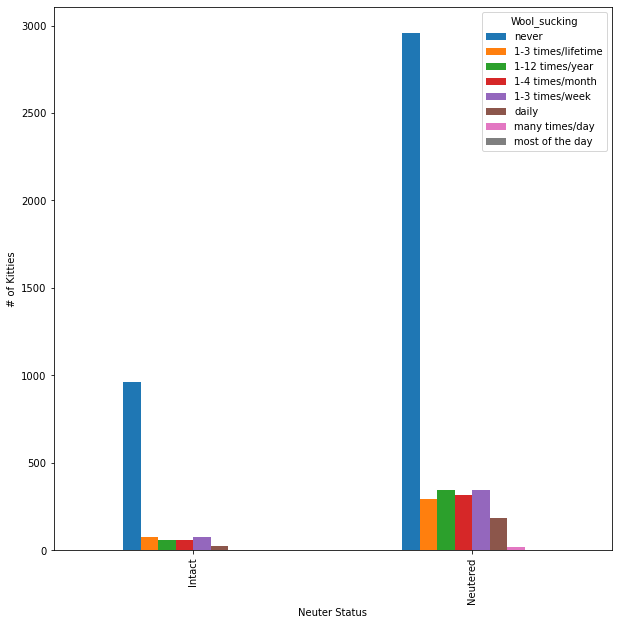

In [16]:
# Netuer Status Grouped Bar
ns.plot(kind='bar', figsize=(10,10))
plt.xlabel('Neuter Status')
plt.xticks(xns, ['Intact', 'Neutered'])
plt.ylabel('# of Kitties');

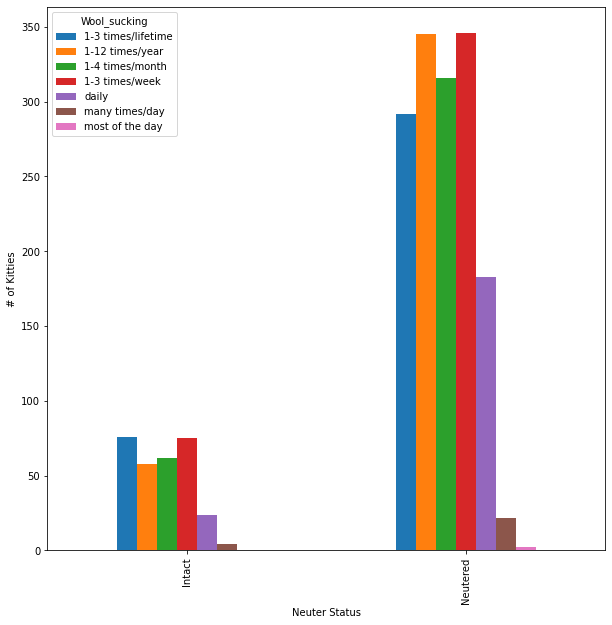

In [17]:
# Better Scale, No 'never' responses to WS 
ns_nows0 = ns.drop(columns='never')
ns_nows0.plot(kind='bar', figsize=(10,10))
plt.xlabel('Neuter Status')
plt.xticks(xns, ['Intact', 'Neutered'])
plt.ylabel('# of Kitties');

In [18]:
# How many intact vs neutered?
cat_data.Neuter_status.value_counts()

1    4465
0    1261
Name: Neuter_status, dtype: int64

In [19]:
# Proportions of WS scores for Intact Cats
i = cat_data.loc[(cat_data['Neuter_status'] == 0), 'Wool_sucking'].value_counts(normalize=True)

In [20]:
# Proportions of WS scores for Neutered Cats
n = cat_data.loc[(cat_data['Neuter_status'] == 1), 'Wool_sucking'].value_counts(normalize=True)

# Observations:
The difference between neutered and intact kitties seems great, but there are also like 3x neutered cats than intact. The distribution of scores is fairly similar:

          never  1-3 times/lifetime  1-12 times/year  1-4 times/month  \
intact    0.762               0.254            0.194            0.207   
neutered  0.661               0.194            0.230            0.210   

          1-3 times/week  daily  many times/day  most of the day  
intact             0.251  0.080           0.013            0.000  
neutered           0.230  0.122           0.015            0.001  


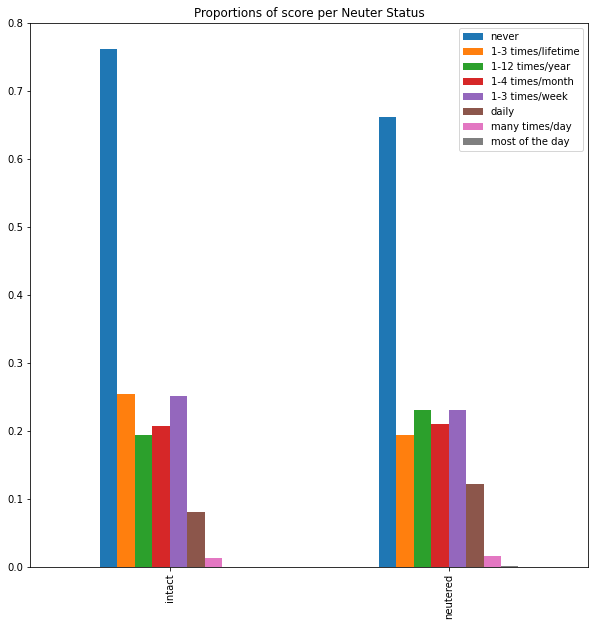

In [21]:
df = pd.DataFrame({0:[0.762, 0.661],1:[0.254, 0.194], 2:[0.194, 0.230], 3:[0.207, 0.210], 4:[0.251, 0.230], 5:[0.080, 0.122], 6:[0.013, 0.015], 7:[0, 0.001]})
df.rename(index={0:'intact', 1:'neutered'}, inplace=True)
df.rename(columns=word_cols, inplace=True)
df.plot(kind='bar', figsize=(10, 10))
print(df)
plt.title('Proportions of score per Neuter Status');

In [22]:
# NO. NAUGHTY. THIS (chi2 on normalized data) ISN'T HOW THIS WORKS. TOO MANY LAMBDAS, BABY.  
stat, p, dof, expected = stats.chi2_contingency(df)
p

0.9999999778349481

## I need interpretation help:
A) Does what I did there make logical sense? Is it a no-no to chi2 on proportions? Did I incorporate far too much rounding error in building the df used in chi2 manually? 

B) Does this mean there's no correlation between the proportion of scores and neuter status and is that the same thing as saying there's no correlation between them in general (contrary to initial heatmap finding)? If so, how were the scores so different between the two methods??

# Breed Group - Grouped Bar

In [23]:
# Breed Group Contingency Tab 
bg = pd.crosstab(cat_data.Breed_group, cat_data.Wool_sucking)
bg = bg.rename(columns=new_cols)
xbg = bg.index

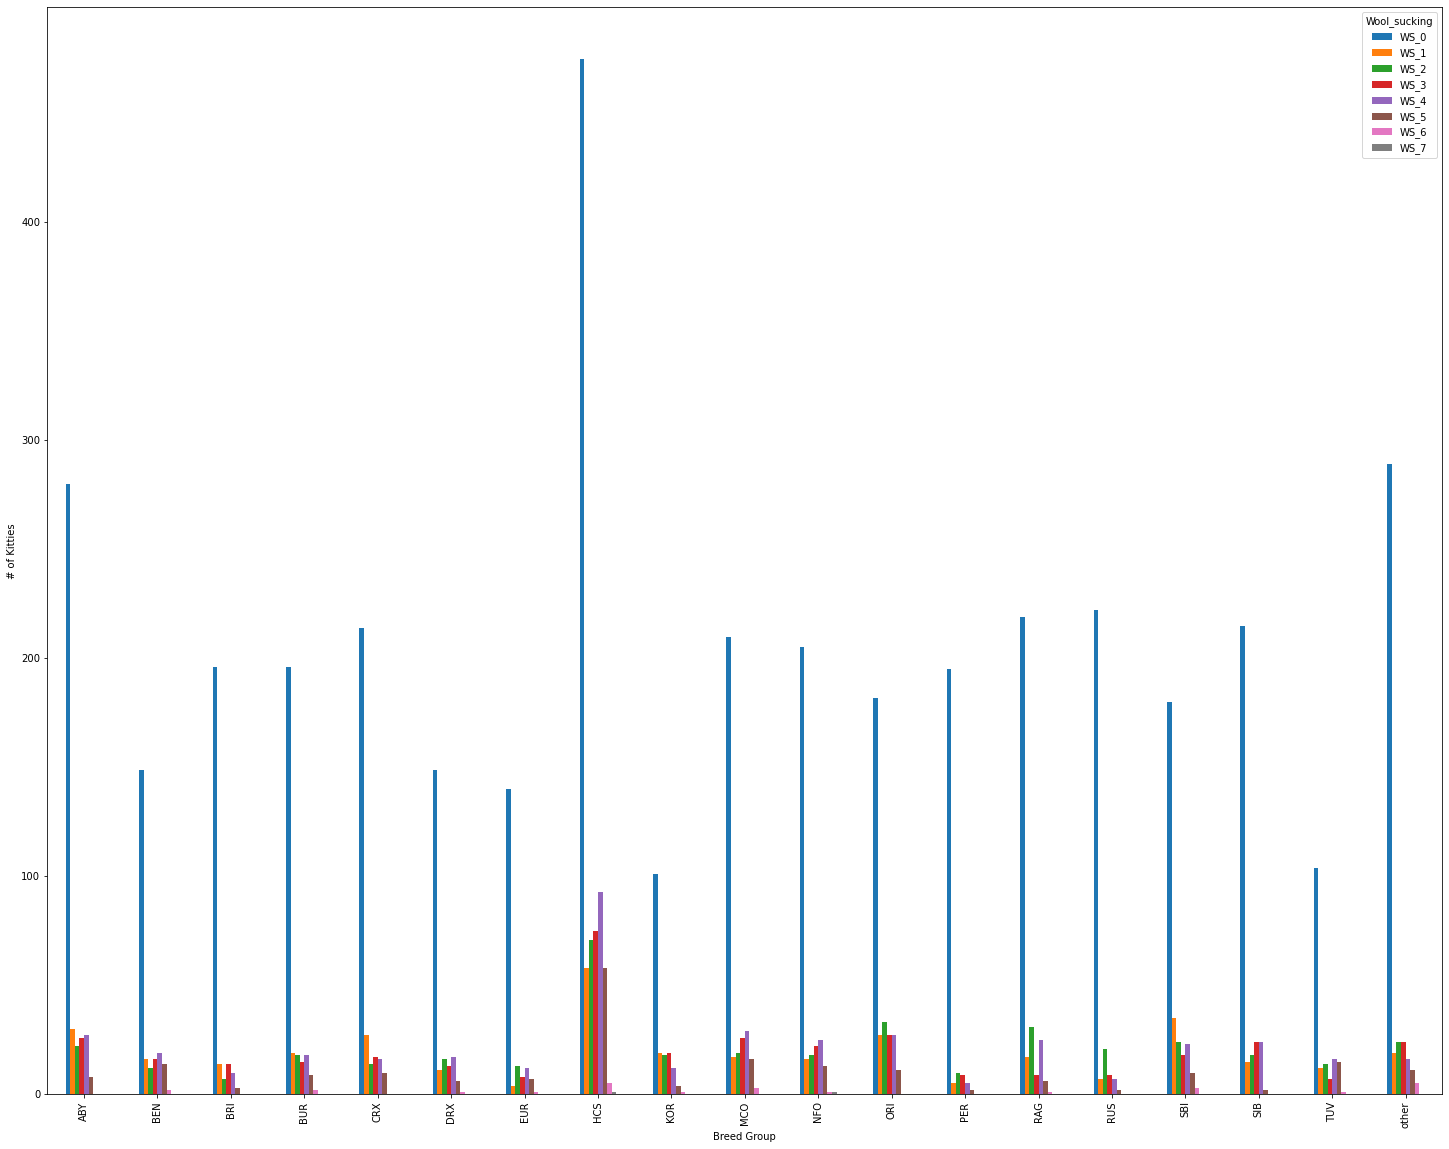

In [24]:
# Breed Group Plot 
bg.plot(kind='bar', figsize=(25,20))
plt.xlabel('Breed Group')
plt.ylabel('# of Kitties');

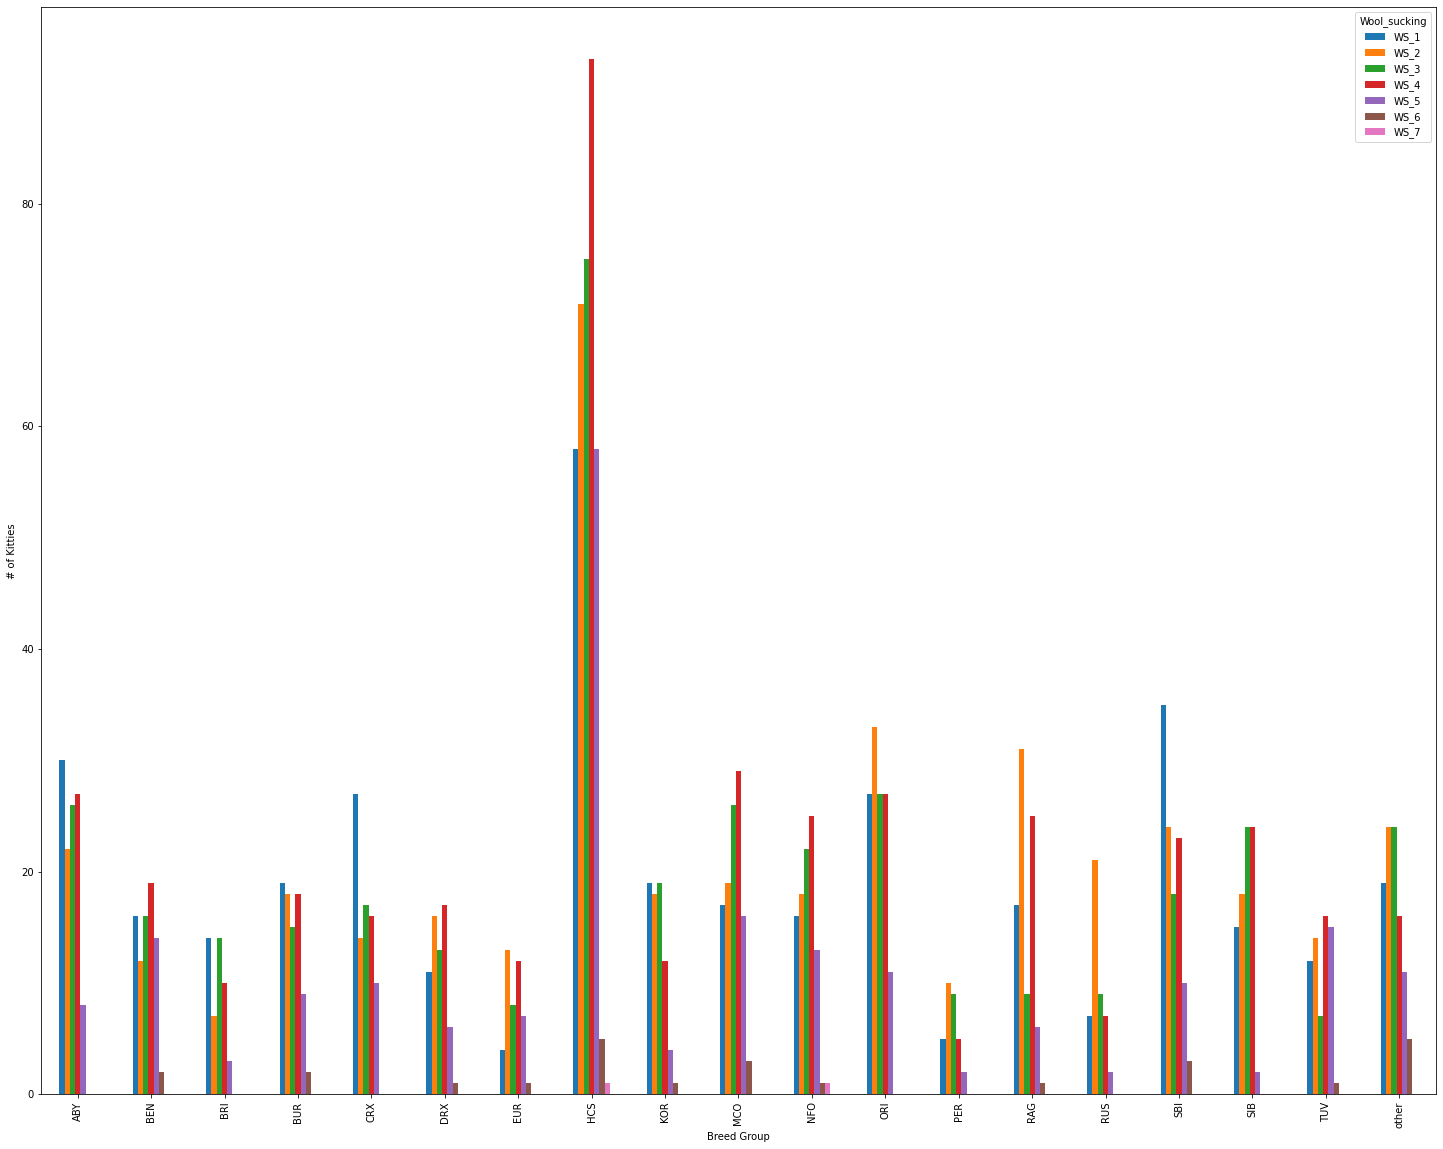

In [25]:
# No 'never' WS responses for BG
bg_nows0 = bg.drop(columns='WS_0')
bg_nows0.plot(kind='bar', figsize=(25,20))
plt.xlabel('Breed Group')
plt.ylabel('# of Kitties');

In [26]:
# Splitting breeds into groups so I can actually see what the heck is going on here 
g1 = cat_data.loc[cat_data['Breed_group'].isin(['ABY', 'BEN', 'BRI', 'BUR', 'CRX', 'DRX']), ['Breed_group', 'Wool_sucking']]
g2 = cat_data.loc[cat_data['Breed_group'].isin(['EUR', 'HCS', 'KOR', 'MCO', 'NFO', 'ORI']), ['Breed_group', 'Wool_sucking']]
g3 = cat_data.loc[cat_data['Breed_group'].isin(['PER', 'RAG', 'RUS', 'SBI', 'SIB', 'TUV', 'other']), ['Breed_group', 'Wool_sucking']]

In [27]:
g1 = pd.crosstab(g1.Breed_group, g1.Wool_sucking)
g2 = pd.crosstab(g2.Breed_group, g2.Wool_sucking)
g3 = pd.crosstab(g3.Breed_group, g3.Wool_sucking)

In [28]:
g1 = g1.rename(columns=word_cols)
g2 = g2.rename(columns=word_cols)
g3 = g3.rename(columns=word_cols)

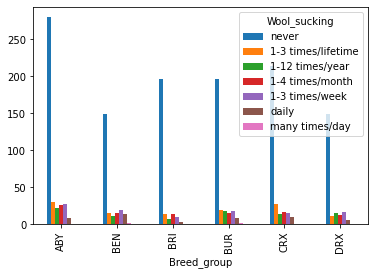

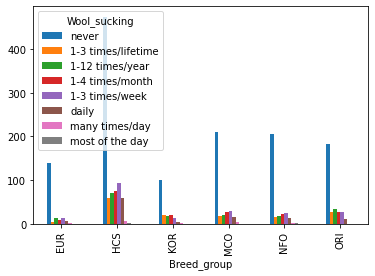

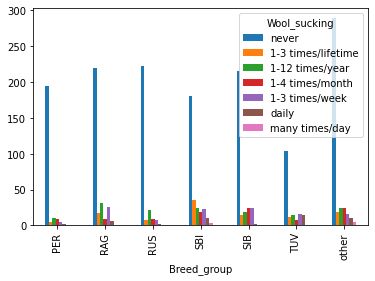

In [29]:
g1.plot(kind='bar')
g2.plot(kind='bar')
g3.plot(kind='bar');

In [30]:
# For better scale
g1 = g1.drop(columns='never')
g2 = g2.drop(columns='never')
g3 = g3.drop(columns='never')

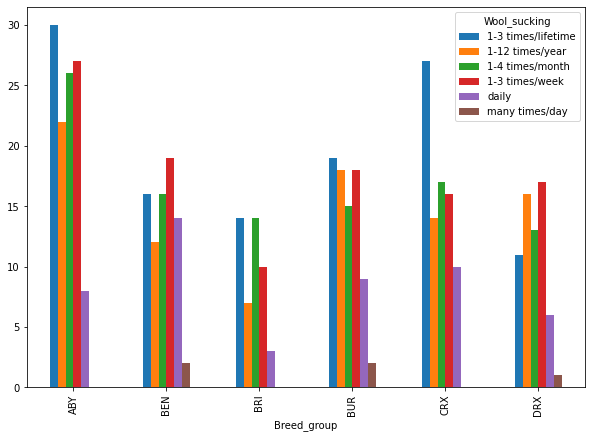

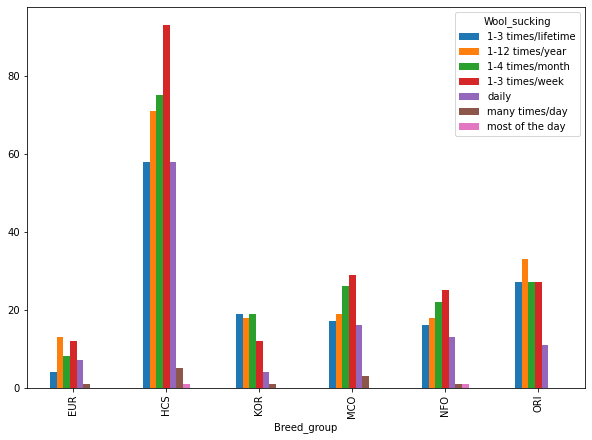

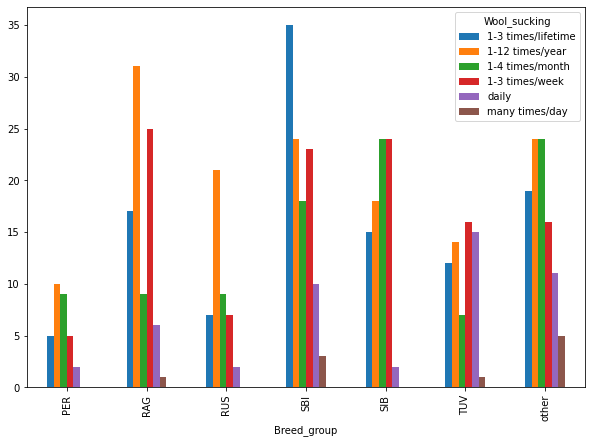

In [31]:
g1.plot(kind='bar', figsize=(10,7))
g2.plot(kind='bar', figsize=(10,7))
g3.plot(kind='bar', figsize=(10,7));

In [32]:
stat, p, dof, expected = stats.chi2_contingency(bg)
round(p, 5)

0.0

## Observations
I'd say the variability here is considerate and aligns with the heatmap score. 

## 05/03/2023 

In [33]:
cat_data.head()

,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem,Aggression_component,Shyness_component,Extraversion_component
0,4.0274,2,1,BEN,8,0,1,4,5,1,1,1,2,1,1.0,0.0,1.0,-0.392731,-0.364198,0.666318
1,2.1096,2,1,BEN,8,0,1,5,4,1,1,1,3,3,1.0,0.0,1.0,-0.633626,1.419777,0.994083
2,7.6822,1,1,BUR,4,0,1,4,5,1,1,1,2,1,4.0,3.0,2.0,-0.392731,-0.364198,0.666318
3,5.0027,1,1,BUR,4,4,0,5,5,1,1,2,1,1,1.0,0.0,1.0,0.090309,-0.780989,1.330449
4,5.0137,1,1,EUR,4,5,1,4,5,1,1,1,2,1,1.0,0.0,1.0,-0.392731,-0.364198,0.666318


In [34]:
# for ease of coding later, also I won't be using these components. I'll probably just calculate my own later just to show
# that I can. 
df = cat_data.drop(columns=['Aggression_component', 'Shyness_component', 'Extraversion_component'])

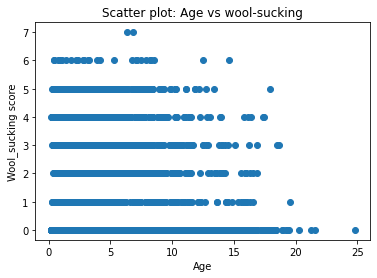

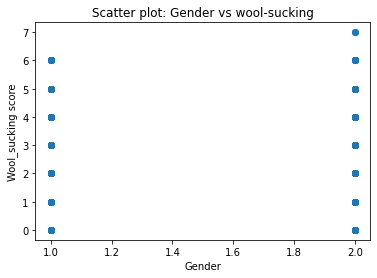

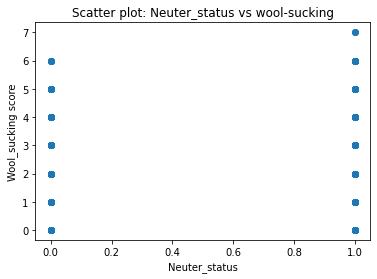

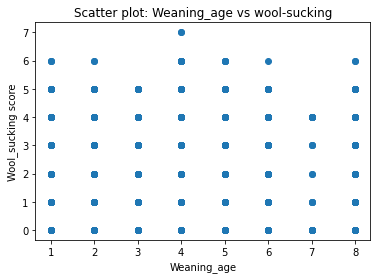

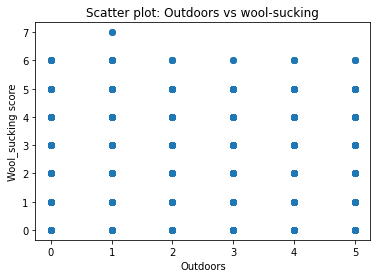

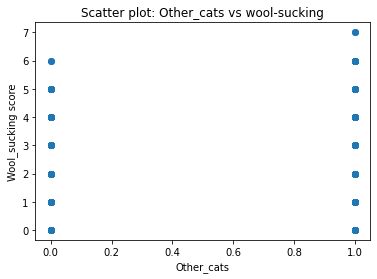

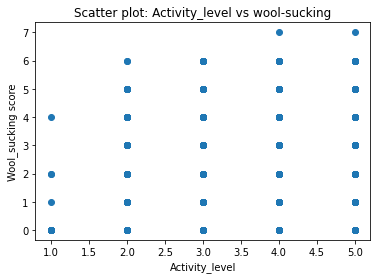

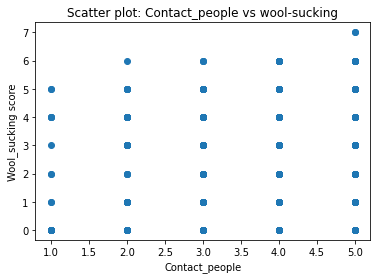

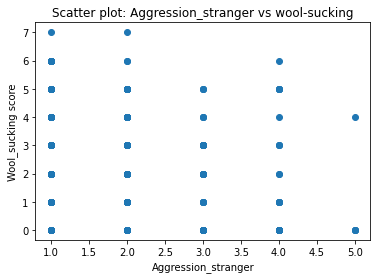

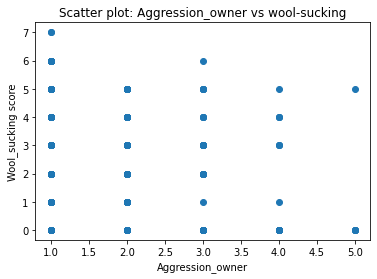

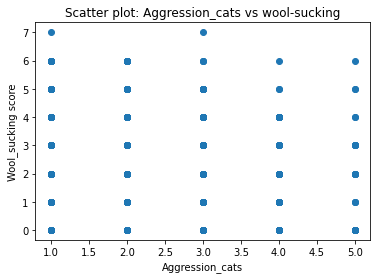

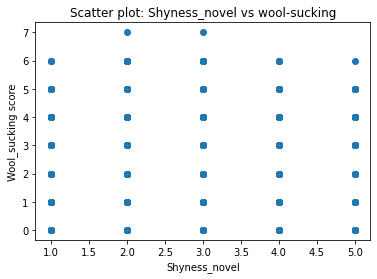

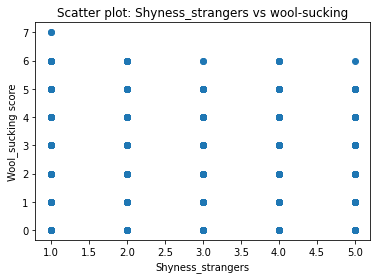

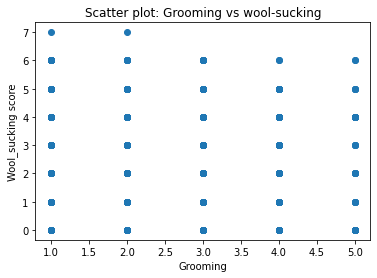

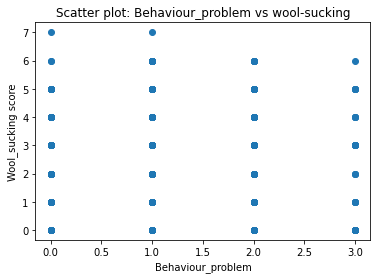

In [35]:
# scatter plots of wool-sucking against everything but breed (since I haven't encoded that yet)
variables_to_compare = df.drop(columns=['Wool_sucking', 'Breed_group']).columns

for variable in variables_to_compare:
    plt.scatter(df[variable], df['Wool_sucking'])
    plt.xlabel(variable)
    plt.ylabel('Wool_sucking score')
    plt.title(f'Scatter plot: {variable} vs wool-sucking')
    plt.show()

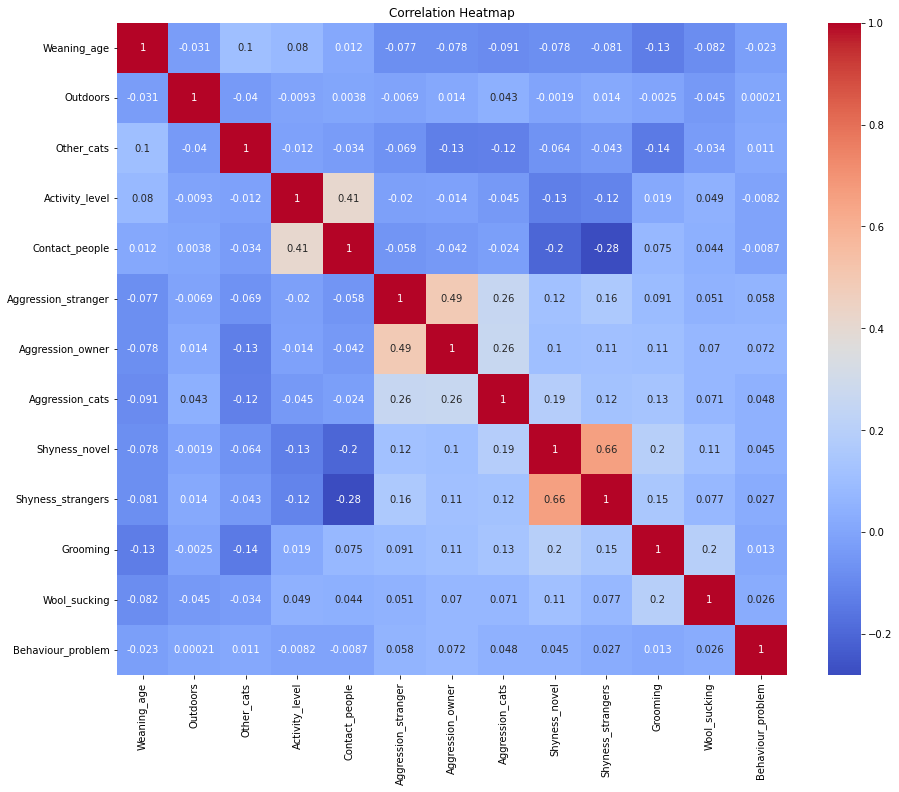

In [36]:
vars = df.drop(columns=['Age', 'Gender', 'Neuter_status']).columns

corr_matrix = df[vars].corr(method='kendall') # apparently kendall is the man for ordinal data
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Wool sucking is most strongly coordinated (0.2>c>0.07, which isn't saying much) with (+)Grooming, (+)shyness to novel situations, (-) weaning age (makes sense, the stronger the wool sucking score the earlier they were weaned), (+) shyness with strangers, and (+) aggression to owner and cats. 

In [37]:
# 0-2 = no sucking, 3-7 = sucking 
df['ws_binary'] = df['Wool_sucking'].replace({1:0, 2:0, 3:1, 4:1, 5:1, 6:1, 7:1})
df.head()

,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Wool_sucking,Behaviour_problem,ws_binary
0,4.0274,2,1,BEN,8,0,1,4,5,1,1,1,2,1,1.0,0.0,1.0,0.0
1,2.1096,2,1,BEN,8,0,1,5,4,1,1,1,3,3,1.0,0.0,1.0,0.0
2,7.6822,1,1,BUR,4,0,1,4,5,1,1,1,2,1,4.0,3.0,2.0,1.0
3,5.0027,1,1,BUR,4,4,0,5,5,1,1,2,1,1,1.0,0.0,1.0,0.0
4,5.0137,1,1,EUR,4,5,1,4,5,1,1,1,2,1,1.0,0.0,1.0,0.0


In [38]:
df_log = df.drop(columns='Wool_sucking')

In [39]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5726 entries, 0 to 5725
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5726 non-null   float64
 1   Gender               5726 non-null   int64  
 2   Neuter_status        5726 non-null   int64  
 3   Breed_group          5726 non-null   object 
 4   Weaning_age          5726 non-null   int64  
 5   Outdoors             5726 non-null   int64  
 6   Other_cats           5726 non-null   int64  
 7   Activity_level       5726 non-null   int64  
 8   Contact_people       5726 non-null   int64  
 9   Aggression_stranger  5726 non-null   int64  
 10  Aggression_owner     5726 non-null   int64  
 11  Aggression_cats      5726 non-null   int64  
 12  Shyness_novel        5726 non-null   int64  
 13  Shyness_strangers    5726 non-null   int64  
 14  Grooming             5726 non-null   float64
 15  Behaviour_problem    5726 non-null   f

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

In [41]:
# integer encode Breed_group
label_encoder = LabelEncoder()

df_log['Breed_group'] = label_encoder.fit_transform(df_log['Breed_group'])
df_log.head()

,Age,Gender,Neuter_status,Breed_group,Weaning_age,Outdoors,Other_cats,Activity_level,Contact_people,Aggression_stranger,Aggression_owner,Aggression_cats,Shyness_novel,Shyness_strangers,Grooming,Behaviour_problem,ws_binary
0,4.0274,2,1,1,8,0,1,4,5,1,1,1,2,1,1.0,1.0,0.0
1,2.1096,2,1,1,8,0,1,5,4,1,1,1,3,3,1.0,1.0,0.0
2,7.6822,1,1,3,4,0,1,4,5,1,1,1,2,1,4.0,2.0,1.0
3,5.0027,1,1,3,4,4,0,5,5,1,1,2,1,1,1.0,1.0,0.0
4,5.0137,1,1,6,4,5,1,4,5,1,1,1,2,1,1.0,1.0,0.0


In [42]:
# assign X and y
X = df_log.drop(columns='ws_binary')
y = df_log['ws_binary']

In [43]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5726 entries, 0 to 5725
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  5726 non-null   float64
 1   Gender               5726 non-null   int64  
 2   Neuter_status        5726 non-null   int64  
 3   Breed_group          5726 non-null   int32  
 4   Weaning_age          5726 non-null   int64  
 5   Outdoors             5726 non-null   int64  
 6   Other_cats           5726 non-null   int64  
 7   Activity_level       5726 non-null   int64  
 8   Contact_people       5726 non-null   int64  
 9   Aggression_stranger  5726 non-null   int64  
 10  Aggression_owner     5726 non-null   int64  
 11  Aggression_cats      5726 non-null   int64  
 12  Shyness_novel        5726 non-null   int64  
 13  Shyness_strangers    5726 non-null   int64  
 14  Grooming             5726 non-null   float64
 15  Behaviour_problem    5726 non-null   f

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [45]:
log = LogisticRegression()
log.fit(X_train, y_train)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Is that bad? ^ I don't know what this means :( 

In [46]:
y_pred = log.predict(X_test)

In [47]:
y_pred_probs = log.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

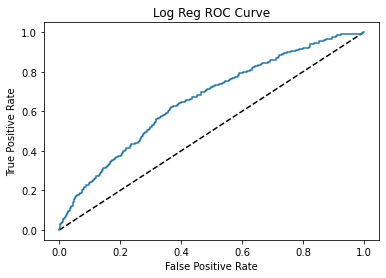

In [48]:
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Log Reg ROC Curve")
plt.show()

In [49]:
roc_auc_score(y_test,y_pred_probs)

0.6577277309384165

Only 31.6% better than chance :/ not superb. 

## Hyperparamter Tuning?

In [58]:
param_grid = {
    'C': [0.1],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [1000, 1500, 2000]
}

grid_search = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Best Hyperparameters:  {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}
Best Score:  0.6567888426304768


Not sure how that's the best score when ours from earlier was literally better. 

In [59]:
param_grid = {
    'C': [0.1, 'none'],
    'penalty': ['l1', 'l2', 'none'],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter' : [1000, 1500, 2000]
}

grid_search = GridSearchCV(log, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X, y)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1483: UserWarning: Setting penalt

Best Hyperparameters:  {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'sag'}
Best Score:  0.6567816295043128


C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\gwent\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Va